# Competition Assignment


## Import all libraries

In [1]:
import numpy as np
import tensorflow as tf
import os
from svhn_helper import SVHN
from matplotlib import pyplot as plt

## Investigate the data

Percentage of labels in train and validation set
          train | validation
     -----------------------
    1  0.067706 |   0.066075
    2  0.189438 |   0.187167
    3  0.144391 |   0.145392
    4  0.116089 |   0.115085
    5  0.101817 |   0.101706
    6  0.093794 |   0.095290
    7  0.078535 |   0.074949
    8  0.076291 |   0.077133
    9  0.068616 |   0.071126
   10  0.063323 |   0.066075


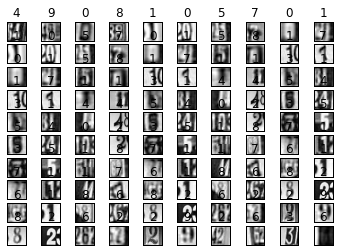

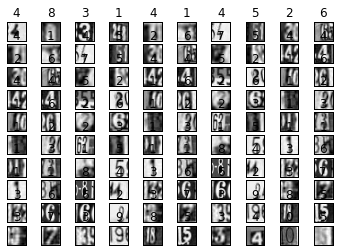

In [2]:
# Create the Data loader object
svhn = SVHN()

def print_statistics():
    ############################################################################
    #                         Print class distribution                         #
    ############################################################################
    train_labels      = svhn._training_labels
    validation_labels = svhn._validation_labels
    train_dist        = np.histogram(train_labels)[0] / len(train_labels)
    validation_dist   = np.histogram(validation_labels)[0]  / len(validation_labels)
    print('Percentage of labels in train and validation set')
    print('%15s | %10s' % ('train', 'validation'))
    print(' ' * 5 + '-' * 23)
    for index, (t, v) in enumerate(zip(train_dist, validation_dist)):
        print('%5d%10f | %10f' % (index + 1, t, v))

def plot(N=100):

    N_train, N_val = svhn.get_sizes()[:2]
    random_indices_train = np.random.choice(N_train, N, replace=False)
    random_indices_val = np.random.choice(N_val, N, replace=False)

    train_batch = list(zip(svhn._training_data[random_indices_train],
        svhn._training_labels[random_indices_train]))

    val_batch = list(zip(svhn._validation_data[random_indices_val],
        svhn._validation_labels[random_indices_val]))

    categories = ['0','1','2','3','4','5','6','7','8','9','0']
    h, w = (int(np.floor(np.sqrt(N))), int(np.ceil(np.sqrt(N))))
    f_train, axarr_train = plt.subplots(h, w)
    f_val, axarr_val = plt.subplots(h, w)
    for i in range(h):
        for j in range(w):
            index = 4*i+j

            ax_train = axarr_train[i][j]
            ax_val = axarr_val[i][j]

            img_train = train_batch[index][0].reshape((32,32))
            img_val = val_batch[index][0].reshape((32,32))

            label_train = train_batch[index][1]
            label_val = val_batch[index][1]

            ax_train.set_title(categories[label_train])
            ax_train.imshow(img_train, cmap='gray')
            ax_train.get_xaxis().set_visible(False)
            ax_train.get_yaxis().set_visible(False)

            ax_val.set_title(categories[label_val])
            ax_val.imshow(img_val, cmap='gray')
            ax_val.get_xaxis().set_visible(False)
            ax_val.get_yaxis().set_visible(False)
    plt.show()

print_statistics()
plot()


## Model Helper
Now we are creating some model helper classes and functions in order to ease the process of training and model handling.
### Model Class
This class acts as an abstract base class for our network models.

In [3]:
class BaseModel(object):
    '''Base model class.

    Attributes
    ----------
    opt   :   str
                    TF optimizer to use
    act_fn  :   function
                    tf.nn function for neuron activation
    '''

    def run_training_step(self, session, data, labels):
        '''Run forward pass through net and apply gradients once.

        Parameters
        ----------
        session :   tf.Session
                    Session to use for executing everything
        data    :   np.ndarray
                    Input data
        labels  :   np.ndarray
                    Input labels
        '''
        pass

    def get_accuracy(self, session, data, labels):
        '''Run forward pass through net and compute accuracy.

        Parameters
        ----------
        session :   tf.Session
                    Session to use for executing everything
        data    :   np.ndarray
                    Input data
        labels  :   np.ndarray
                    Input labels

        Returns
        -------
        float
        '''
        pass

    def __init__(self, optimizer, activation):
        '''Init new model

        Parameters
        ----------
        lr  :   float
                Learning rate for the optimizer
        optimizer   :   tf.train.Optimizer
                        TF optimizer to use
        activation  :   function
                        tf.nn function for neuron activation
        '''
        self.opt = optimizer
        self.act_fn = activation


### Utility Functions

In [4]:
import sys
import argparse
import importlib
import tensorflow as tf
import numpy as np

SEED = 5
np.random.seed(SEED)
tf.set_random_seed(SEED)

pool_n = 0


def max_pool_layer(input, ksize, strides):
    global pool_n
    pool_n += 1
    with tf.variable_scope('pool%d' % pool_n):
        return tf.nn.max_pool(input,
                ksize=ksize, strides=strides, padding='SAME')

conv_n = 0


def conv_layer(input, kshape, strides=(1, 1, 1, 1), activation=tf.nn.tanh):
    '''Create a convolutional layer with fixed activation function and variable
    initialisation. The activation function is ``tf.nn.tanh`` and variables are
    initialised from a truncated normal distribution with an stddev of 0.1

    Parameters
    ----------
    input   :   tf.Variable
                Input to the layer
    kshape  :   tuple or list
                Shape of the kernel tensor
    strides :   tuple or list
                Strides

    Returns
    -------
    tf.Variable
            The variable representing the layer activation (tanh(conv + bias))

    '''
    global conv_n
    conv_n += 1
    # this adds a prefix to all variable names
    with tf.variable_scope('conv%d' % conv_n):
        kernels = tf.Variable(
            tf.truncated_normal(
                kshape,
                stddev=0.1),
            kshape, name='kernels')
        bias_shape = (kshape[-1],)
        biases = tf.Variable(
            tf.truncated_normal(
                bias_shape,
                stddev=0.1), name='bias')
        conv = tf.nn.conv2d(
            input,
            kernels,
            strides,
            padding='SAME',
            name='conv')
        return activation(tf.nn.tanh(conv + biases, name='activation'))


# counter for autmatically creating fully-connected layer variable names
fc_n = 0


def fully_connected(input, n_out, with_activation=False, activation=tf.nn.tanh):
    '''Create a fully connected layer with fixed activation function and variable
    initialisation. The activation function is ``tf.nn.tanh`` and variables are
    initialised from a truncated normal distribution with an stddev of 0.1

    Parameters
    ----------
    input   :   tf.Variable
                Input to the layer
    n_out   :   int
                Number of neurons in the layer
    with_activation :   bool
                        Return activation or drive (useful when planning to use
                        ``softmax_cross_entropy_with_logits`` which requires
                        unscaled logits)


    Returns
    -------
    tf.Variable
            The variable representing the layer activation (tanh(input * Weights
            + bias))
    '''
    global fc_n
    fc_n += 1
    with tf.variable_scope('fully%d' % fc_n):
        init = tf.truncated_normal_initializer(stddev=0.1)
        W = tf.get_variable(
                'weights',
                initializer=init,
                shape=(input.shape[-1], n_out), # the last dim of the input
               dtype=tf.float32                 # is the 1st dim of the weights
            )
        bias = tf.get_variable('bias', initializer=init, shape=(n_out,))
        drive = tf.matmul(input, W) + bias
        if with_activation:
            return activation(drive)
        else:
            return drive

# counter for autmatically creating fully-connected layer variable names
bn_n = 0


def batch_normalization_layer(input_layer, dimension):
    '''Helper function to do batch normalziation

    Parameters
    ----------
    input_layer :   tf.Tensor
                    4D tensor
    dimension   :   int
                    input_layer.get_shape().as_list()[-1]. The depth of the 4D tensor
    Returns
    -------
    tf.Tensor
           Tthe 4D tensor after being normalized
    '''
    global bn_n
    bn_n += 1
    with tf.variable_scope('batch_norm%d' % bn_n):
        mean, variance = tf.nn.moments(input_layer, axes=[0, 1, 2])
        # normalise by mean and variance, and use no offset or scaling (0, 1)
        bn_layer = tf.nn.batch_normalization(input_layer, mean, variance, None,
                None, 0.001)

        return bn_layer

# counter for autmatically creating fully-connected layer variable names
weighted_pool_n = 0


def weighted_pool_layer(input_layer, ksize, strides=(1, 1, 1, 1)):
    '''Helper function to do mixed max/avg pooling

    Parameters
    ----------
    input_layer :   tf.Tensor
                    4D tensor
    Returns
    -------
    tf.Tensor
           Tthe 4D tensor after being pooled
    '''
    global weighted_pool_n
    weighted_pool_n += 1
    with tf.variable_scope('weight_pool%d' % weighted_pool_n):
        a = tf.get_variable('a',
                initializer=tf.truncated_normal_initializer(),
                shape=(1,),
                dtype=tf.float32, trainable=True)
        max_pool = tf.nn.max_pool(input_layer, ksize, strides, padding='SAME')
        avg_pool = tf.nn.avg_pool(input_layer, ksize, strides, padding='SAME')
        pool = (a * max_pool + (1 - a) * avg_pool)
        return pool

inc_n = 0

def inception2d(x, in_channels, filter_count):
    '''Helper function to create inception module

    Parameters
    ----------
    in_channels :   int
                    number of input channels
    filter_count    :   int
                        number of filters to use for soemthing ?

    Returns
    -------
    tf.Tensor
           Tensor with filter_count*3 +1 output channels
    '''
    global inc_n
    inc_n += 1
    with tf.variable_scope('inception%d' % inc_n):
        # bias dimension = 3*filter_count and then the extra in_channels for the avg
        # pooling
        bias = tf.Variable(tf.truncated_normal([3*filter_count + in_channels]))

        # 1x1
        one_filter = tf.Variable(tf.truncated_normal([1, 1, in_channels,
            filter_count]))
        one_by_one = tf.nn.conv2d(x, one_filter,
                    strides=[1, 1, 1, 1], padding='SAME')

        # 3x3
        three_filter = tf.Variable(tf.truncated_normal([3, 3, in_channels,
            filter_count]))
        three_by_three = tf.nn.conv2d(x,
                    three_filter, strides=[1, 1, 1, 1], padding='SAME')

        # 5x5
        five_filter = tf.Variable(tf.truncated_normal([5, 5, in_channels,
            filter_count]))
        five_by_five = tf.nn.conv2d(x, five_filter,
                    strides=[1, 1, 1, 1], padding='SAME')

        # avg pooling
        pooling = tf.nn.avg_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1],
                padding='SAME')

        x = tf.concat([one_by_one, three_by_three, five_by_five, pooling], axis=3)
        # Concat in the 4th dim to stack
        x = tf.nn.bias_add(x, bias)
        return tf.nn.relu(x)


class ParameterTest(object):
    '''Test one set of parameters to the train() function.'''
    def __init__(self, model, batch_size, epochs,
            train_function):
        self.model = model
        self.batch_size = batch_size
        self.epochs = epochs
        self.accuracy = None
        self.train_function=train_function

    def run(self):
        '''Run the training process with the specified settings.'''

        save_fname = '{name}_{batch}_{lr}_{epochs}_{opti}_{act}.ckpt'.format(
                name   = self.model.__class__.__name__,
                batch  = self.batch_size,
                lr     = self.model.opt._learning_rate,
                epochs = self.epochs,
                opti   = self.model.opt.get_name(),
                act    = self.model.act_fn.__name__
        )
        self.accuracy = self.train_function(self.model, self.batch_size,
                self.epochs, save_fname, return_records=False, record_step=30)

    def __str__(self):
        return ('{opti:30}, learning rate={lr:5.4f}, batch size={bs:<5d}, '
                'epochs={epochs:<5d}, accuracy={acc:4.3f}'.format(
                    opti   = self.model.opt,
                    lr     = self.model.lr,
                    bs     = self.batch_size,
                    epochs = self.epochs,
                    acc    = self.accuracy
                )
        )



## Actual training model
Here we are creating our actual training model which basically implements the functions defined in our abstract model class above.

In [5]:
class Model(BaseModel):
    '''Smaller model so we clock in at < 4mb'''

    def run_training_step(self, session, data, labels):
        '''Docs --> see BaseModel'''
        entropy, _ = session.run(
            [self.mean_cross_entropy, self.train_step],
            feed_dict={self.x: data, self.y_: labels})
        return entropy

    def get_accuracy(self, session, data, labels):
        '''Docs --> see BaseModel'''
        return session.run([self.accuracy], feed_dict={self.x: data, self.y_:
            labels})[0]


    def __init__(self, optimizer, activation):
        '''Docs --> see BaseModel'''
        super().__init__(optimizer, activation)

        ############################################################################
        #                             Define the graph                             #
        ############################################################################
        # It turns out that this network from ex03 is already capable of memorizing
        # the entire training or validation set, so we need to tweak generalization,
        # not capacity
        x  = tf.placeholder(tf.float32, shape=(None, 32, 32, 1), name='input')
        y_ = tf.placeholder(dtype=tf.int32, shape=(None,), name='labels')

        self.x = x
        self.y_ = y_

        kernel_shape1 = (8, 8, 1, 8)
        activation1 = conv_layer(x, kernel_shape1, activation=activation)

        pool1 = weighted_pool_layer(
            activation1, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1)
        )

        kernel_shape2 = (3, 3, 8, 10)
        activation2 = conv_layer(pool1, kernel_shape2, activation=activation)

        pool2 = weighted_pool_layer(
            activation2, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1)
        )

        pool2_reshaped = tf.reshape(pool2, (-1, 8*8*10), name='reshaped1')
        fc1 = fully_connected(pool2_reshaped, 512, with_activation=True,
                activation=activation)

        fc2_logit = fully_connected(fc1, 10, activation=activation)

        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=fc2_logit,
                                                                labels=y_)
        mean_cross_entropy = tf.reduce_mean(cross_entropy)
        self.mean_cross_entropy = mean_cross_entropy
        train_step = optimizer.minimize(mean_cross_entropy)
        self.train_step = train_step

        # check if neuron firing strongest coincides with max value position in real
        # labels
        correct_prediction = tf.equal(tf.argmax(fc2_logit, 1, output_type=tf.int32), y_)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.accuracy = accuracy



## Training Functionality
Here we are creating a function that will train our network. Additionally the trained weights are saved.

In [6]:
def train_model(model, batch_size, epochs, save_fname, return_records=False, record_step=20):
    '''Train a model on the SVHN dataset.

    Parameters
    ----------
    model           :   Model (defined above)
                        The training model.
    batch_size      :   int
                        Size of training batch.
    epochs          :   int
                        Number of times to visit the entire training set.
    save_fname      :   string
                        The filename of the file carrying all the learned variables.
    return_records  :   boolean
                        Determines whether only the final accuracy (False) or a history of all 
                        entropies and accuracies is returned.
    record_step     :   int
                        Accuracy on test set will be recorded every ``record_step`` training steps.

    Returns
    -------
    scalar OR tuple
            If ``return_records`` is set, all entropies and accuracies are returned. Else the final
            accuracy is returned.
    '''
    
    # Get the data loader
    svhn = SVHN()

    # Keep records of performance
    entropies = []
    accuracies = []
    best_accuracy = 0

    with tf.Session() as sess:

        saver = tf.train.Saver()
        if os.path.exists(save_fname + '.meta'):
            print('Using saved weights.')
            saver.restore(sess, save_fname)
            final_accuracy = model.get_accuracy(sess, svhn._validation_data, svhn._validation_labels)
            return final_accuracy
        else:
            sess.run(tf.global_variables_initializer())

            # number of training steps
            training_step = 0

            for epoch in range(epochs):
                print('Starting epoch %d' % epoch)

                # run one batch
                for data, labels in svhn.get_training_batch(batch_size):
                    entropy = model.run_training_step(sess, data, labels)
                    entropies.append(entropy)

                    # compute validation accuracy every record_step steps
                    if training_step % record_step == 0:
                        val_accuracy = model.get_accuracy(sess, svhn._validation_data, svhn._validation_labels)
                        accuracies.append(val_accuracy)
                        # in case we need it later
                        final_accuracy = val_accuracy
                        print('Current validation accuracy %f' % val_accuracy)

                        # save if better
                        if val_accuracy > best_accuracy:
                            print('Saving model.')
                            best_accuracy = val_accuracy
                            saver.save(sess, save_fname)

                    training_step += 1

                    # stop early if convergence too slow
                    # if epoch == 1:
                    #     if val_accuracy < 0.2:
                    #         raise RuntimeError('This isn\'t going anywhere.')

            if training_step % record_step == 1:
                # we just recorded, final_accuracy already correct
                pass
            else:
                # we need to recompute the final accuracy
                final_accuracy = model.get_accuracy(sess, svhn._validation_data,
                                    svhn._validation_labels)
                accuracies.append(final_accuracy)

            if return_records:
                return entropies, accuracies
            else:
                return final_accuracy

In [13]:
optimizer_cls  = getattr(tf.train, 'AdamOptimizer')
optimizer      = optimizer_cls(0.001)
model          = Model(optimizer, tf.nn.relu)
epochs         = 1
batch_size     = 100
entropies,accuracies = train_model(model, batch_size, epochs, "./weights.txt", True, 20)

Starting epoch 0
Current validation accuracy 0.086280
Saving model.
Current validation accuracy 0.193038
Saving model.
Current validation accuracy 0.238908
Saving model.
Current validation accuracy 0.229625
Current validation accuracy 0.298020
Saving model.
Current validation accuracy 0.405051
Saving model.
Current validation accuracy 0.477270
Saving model.
Current validation accuracy 0.550580
Saving model.
Current validation accuracy 0.577065
Saving model.
Current validation accuracy 0.644778
Saving model.
Current validation accuracy 0.641092
Current validation accuracy 0.694744
Saving model.
Current validation accuracy 0.701570
Saving model.
Current validation accuracy 0.729283
Saving model.
Current validation accuracy 0.735700
Saving model.
Current validation accuracy 0.729693
Current validation accuracy 0.727509
Current validation accuracy 0.744846
Saving model.
Current validation accuracy 0.740478
Current validation accuracy 0.745119
Saving model.
Current validation accuracy 0.759

### Plot entropies and accuracies

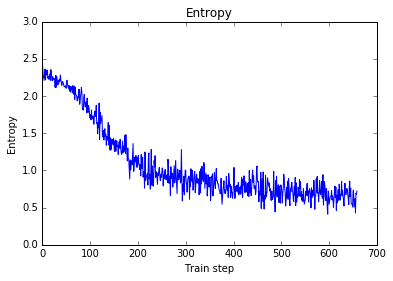

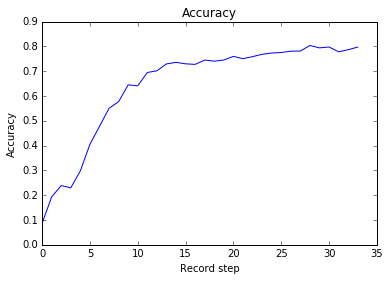

In [17]:
plt.plot(entropies)
plt.title('Entropy')
plt.xlabel('Train step')
plt.ylabel('Entropy')
plt.show()
plt.title('Accuracy')
plt.plot(accuracies)
plt.xlabel('Record step')
plt.ylabel('Accuracy')
plt.show()

## Evaluate the model

In [ ]:
with tf.Session() as session:
    saver = tf.train.Saver()
    saver.restore(session,  tf.train.latest_checkpoint("./weights/"))
    
    test_accuracy = 0
    for step, (images, labels) in enumerate(svhn.get_test_batch(300)):
        test_accuracy += session.run(
            accuracy,
            feed_dict = {x: images, desired: labels}
        )
    
print("Test Accuracy: " + str(test_accuracy / step))